# Analysis of M2 in the US

### Importing the relevant libraries

In [526]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### Importing the dataset

In [527]:
money = pd.read_csv("M2SL.csv")

### Cleaning the dataset

In [528]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786 entries, 0 to 785
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    786 non-null    object 
 1   M2SL    786 non-null    float64
dtypes: float64(1), object(1)
memory usage: 12.4+ KB


In [529]:
money["DATE"] = pd.to_datetime(money["DATE"]).copy()

### Plotting the time-series

Text(0, 0.5, 'M2')

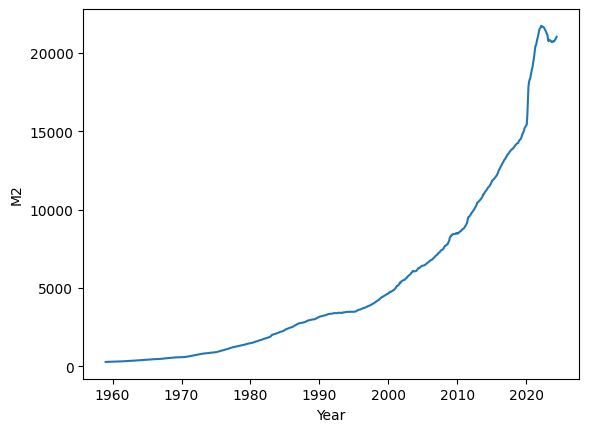

In [530]:
fig, ax = plt.subplots()
ax.plot("DATE", "M2SL", data=money)
ax.set_xlabel("Year")
ax.set_ylabel("M2")

### Testing, if the time-series is stationary

In [531]:
# The time-series is probably not stationary, because mean and variance don't seem to be constant
# Augmented Dickey-Fuller-Test is used for testing

result = adfuller(money["M2SL"])
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
for key, value in result[4].items():
    print("Critical values:")
    print(f"  {key} {value}")

# A p-value which is equal to one is very unlikely but possible due to rounding
# The time-series is non-stationary, because we cannot reject the null-hypothesis

ADF Statistic: 3.434867
p-value: 1.000000
Critical values:
  1% -3.438926964986094
Critical values:
  5% -2.8653254941943174
Critical values:
  10% -2.5687857802554572


### Differencing the time-series

In [532]:
money_diff = money.copy()

money_diff["M2SL"] = money["M2SL"].diff().copy()

### Again testing for non-stationarity

In [533]:
# Drop the row with the missing value
money_diff = money_diff.dropna().copy()

In [534]:
result = adfuller(money_diff["M2SL"])
print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
for key, value in result[4].items():
    print("Critical values:")
    print(f"  {key} {value}")

# The p-value < 0.05, the time-series is now stationary after differencing for one time
# The time-series is therefore integrated by order 1: I(1)

ADF Statistic: -4.657964
p-value: 0.000101
Critical values:
  1% -3.4388933482333464
Critical values:
  5% -2.8653106782623574
Critical values:
  10% -2.5687778874376086


### Plotting the differenced time-series

Text(0, 0.5, 'M2')

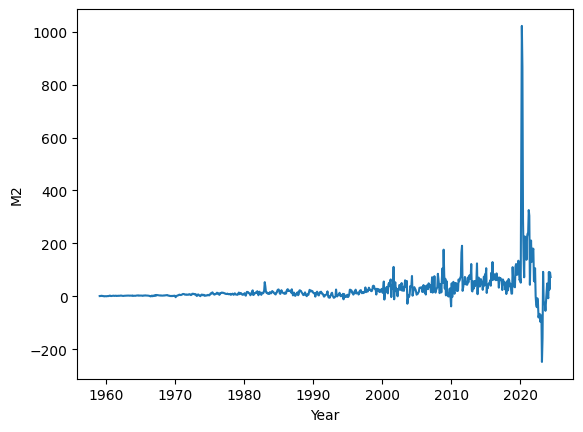

In [535]:
fig, ax = plt.subplots()
ax.plot("DATE", "M2SL", data=money_diff)
ax.set_xlabel("Year")
ax.set_ylabel("M2")

# It is visible, that around 2020 there has been a big increase in the growth-rate of M2, which is probably connected to the COVID-19 pandemic
# Government intervened and tried to keep the american economy from collapsing (this hypothesis is a good topic for future projects)

# Because the original time-series is non-stationary, an ARIMA-model would be a fitting model...

### Using information criteria (Schwarz criterium) to find the optimal number of lags for the model

In [536]:
money_diff = money_diff.set_index("DATE").copy()

In [537]:
# The frequency for the time has to be set
money_diff = money_diff.asfreq("MS")

In [538]:
# First, we'll determine the optimum amount of lags for the AR-model

bic_value_1 = []

for p in range(1, 31):
    ARmodel = AutoReg(money_diff["M2SL"], lags=p).fit()
    bic = ARmodel.bic
    bic_value_1.append(bic)


ARbic = pd.DataFrame({"BIC": [item for item in bic_value_1]})

ARbic.min()

# The BIC-criterium is getting smaller with increasing number of lags without stopping
# Because of this problem, the ACF and PACF are being used to determine the number of lags

BIC    7860.975055
dtype: float64

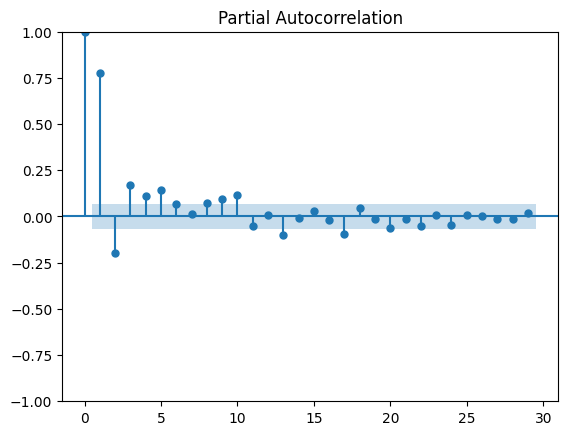

In [539]:
plot_pacf(money_diff["M2SL"])
plt.show()

# After the third lag, the partial autocorrelation seems to almost fall under the confidence bands
# Therefore, 3 lags should be sufficient for the AR-model

In [540]:
# Secondly, we'll determine the optimum amount of lags for the AR-model

bic_value_2 = []

for q in range(1, 21):
    MAmodel = ARIMA(money_diff["M2SL"], order=(0, 0, q)).fit()
    bic = MAmodel.bic
    bic_value_2.append(bic)


MAbic = pd.DataFrame({"BIC": [item for item in bic_value_2]})

print(f"The optimal amount of lags for the MA-model is: {MAbic.idxmin() + 1} lags.")

The optimal amount of lags for the MA-model is: BIC    13
dtype: int64 lags.


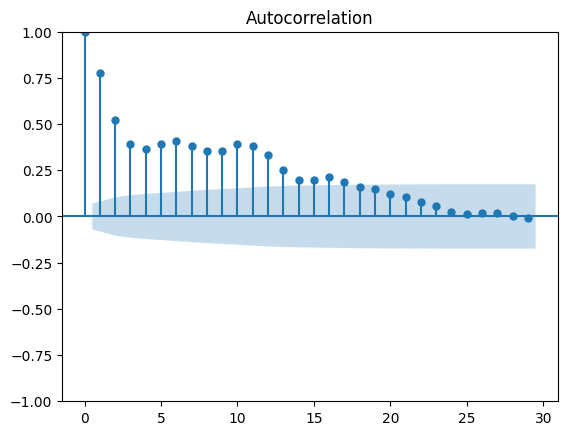

In [541]:
plot_acf(money_diff["M2SL"])
plt.show()

# After lag 13, the autocorrelation starts to go near insignificance
# Therefore 13 lags are sufficient for the MA-model
# This is in line with the BIC-value

### Now, the ARIMA-model will be estimated

In [542]:
# Because the model has problems with finding convergence, we will transform the data to log-data

money["M2SL"] = np.log(money["M2SL"])

In [543]:
model_main = ARIMA(money["M2SL"], order=(3, 1, 13)).fit()

In [544]:
print(model_main.summary())

                               SARIMAX Results                                
Dep. Variable:                   M2SL   No. Observations:                  786
Model:                ARIMA(3, 1, 13)   Log Likelihood                3344.330
Date:                Mon, 12 Aug 2024   AIC                          -6654.660
Time:                        18:11:28   BIC                          -6575.344
Sample:                             0   HQIC                         -6624.163
                                - 786                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7664      0.384      1.994      0.046       0.013       1.520
ar.L2         -0.2947      0.449     -0.656      0.512      -1.175       0.586
ar.L3          0.5085      0.356      1.429      0.1

In [545]:
money["fitted"] = model_main.fittedvalues

In [546]:
money["M2SL"] = np.exp(money["M2SL"]).copy()
money["fitted"] = np.exp(money["fitted"]).copy()
money = money.iloc[2:]

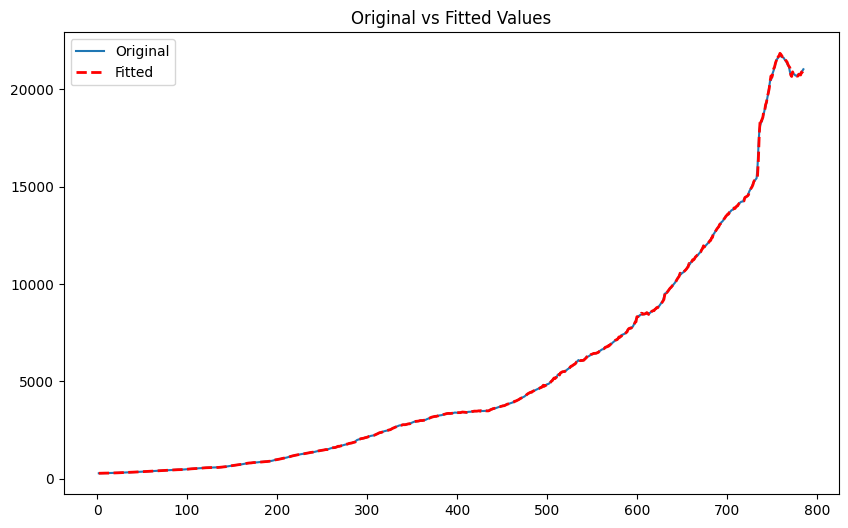

In [547]:
plt.figure(figsize=(10, 6))
plt.plot(money["M2SL"], label='Original')
plt.plot(money["fitted"], color="red", linestyle='--', label='Fitted', linewidth=2, )
plt.title('Original vs Fitted Values')
plt.legend()
plt.show()

# The model seems to fit the data very close (overfitting may be a problem)

## Analysis of residuals

In [548]:
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import acorr_breusch_godfrey

resid = model_main.resid
resid = resid.iloc[2:]

In [549]:
# before we use the tests, we need to transform the log values back

resid = np.exp(resid).copy()

### Jarque-Bera-Test for normality of residuals

In [550]:
jb_test = jarque_bera(resid)
print(f"p-value: {jb_test[1]:.10f}")

# The residuals are not normal
# This is not a big problem, because our sample of observations is big and therefore, the coefficients are distributed normally (CLT)

p-value: 0.0000000000


### White-Test for homoscedasticity of residuals

In [551]:
exog = pd.DataFrame({f'lag_{i}': money["M2SL"].shift(i) for i in range(1, 9)}).dropna()
residuals = resid[-len(exog):]
exog = sm.add_constant(exog)

white_test = het_white(residuals, exog)
print(f'White test statistic: {white_test[0]}, p-value: {white_test[1]}')

# The residuals are strongly heteroscedastic, which makes the estimation of the model unreliable

White test statistic: 228.6667309523497, p-value: 8.831932436116913e-27


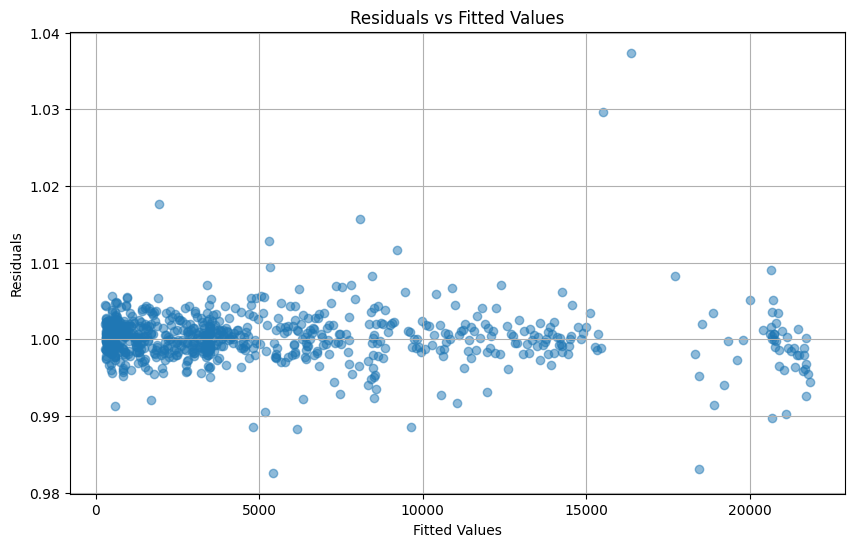

In [552]:
plt.figure(figsize=(10, 6))
plt.scatter(money["fitted"], resid, alpha=0.5)
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

### Breusch-Godfrey-Test for autocorrelation of residuals

In [553]:
bg_test_result = acorr_breusch_godfrey(model_main, nlags=4)

print(f'LM-Statistic: {bg_test_result[0]}')
print(f'p-value: {bg_test_result[1]}')

# p-value > 0.05, there is no autocorrelation of residuals

LM-Statistic: 0.0033800176784049007
p-value: 0.999998573543004


-> Because of heteroscedasticity of residuals, the results of the model have to be interpreted with caution
-> Still, because the model has all the other good attributes, the model is good for prediction